## Milligrad Demo

### Imports and Reproducibility

In [1]:
from milligrad import Tensor
from milligrad.nn import MLP

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

SEED = 0
np.random.seed(SEED)
rng = np.random.default_rng(SEED)

### Data

In [ ]:
mnist = fetch_openml("Fashion-MNIST", version=1, as_frame=False)
X_all = mnist.data.astype(np.float64)
y_all = mnist.target.astype(int)

label_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# 80/10/10 split with stratification for class balance.
X_train_raw, X_temp_raw, y_train, y_temp = train_test_split(
    X_all,
    y_all,
    test_size=0.20,
    random_state=SEED,
    stratify=y_all,
)
X_val_raw, X_test_raw, y_val, y_test = train_test_split(
    X_temp_raw,
    y_temp,
    test_size=0.50,
    random_state=SEED,
    stratify=y_temp,
)

# Fit normalization on train only (prevents leakage).
train_mean = X_train_raw.mean(axis=0, keepdims=True)
train_std = X_train_raw.std(axis=0, keepdims=True)
train_std = np.where(train_std == 0, 1.0, train_std)

X_train = (X_train_raw - train_mean) / train_std
X_val = (X_val_raw - train_mean) / train_std
X_test = (X_test_raw - train_mean) / train_std

n_classes = 10
y_train_onehot = np.eye(n_classes)[y_train]
y_val_onehot = np.eye(n_classes)[y_val]
y_test_onehot = np.eye(n_classes)[y_test]

print(f"Data split | train={X_train.shape}, val={X_val.shape}, test={X_test.shape}")

Train: (56000, 784), Val: (7000, 784), Test: (7000, 784)


### Training

In [3]:
model = MLP(784, [98, 64, 32, 16, 10])

In [4]:
batch_size = 128
learning_rate = 0.01
steps = 50_001
eval_every = 10_000

X_val_t = Tensor(X_val)
y_val_t = Tensor(y_val_onehot)

for step in range(steps):
    idx = rng.choice(len(X_train), batch_size, replace=False)
    X_batch = Tensor(X_train[idx])
    y_batch = Tensor(y_train_onehot[idx])

    model.zero_grad()
    log_probs = model(X_batch).log_softmax(axis=1)
    loss = -(y_batch * log_probs).sum() * (1.0 / batch_size)
    loss.backward()

    for p in model.parameters():
        p.data -= learning_rate * p.grad

    if step % eval_every == 0:
        train_preds = model(Tensor(X_train)).data.argmax(axis=1)
        val_log_probs = model(X_val_t).log_softmax(axis=1)
        val_loss = -(y_val_t * val_log_probs).sum().data / len(X_val)
        val_preds = val_log_probs.data.argmax(axis=1)

        train_acc = (train_preds == y_train).mean()
        val_acc = (val_preds == y_val).mean()
        print(
            f"Step {step:4d} | train_acc={train_acc:.2%} | "
            f"val_acc={val_acc:.2%} | val_loss={val_loss:.4f}"
        )

Step    0 | train_acc=10.74% | val_acc=10.79% | val_loss=3.2121
Step 10000 | train_acc=91.74% | val_acc=88.37% | val_loss=0.3331
Step 20000 | train_acc=95.11% | val_acc=88.26% | val_loss=0.3722
Step 30000 | train_acc=97.34% | val_acc=87.60% | val_loss=0.4716
Step 40000 | train_acc=98.66% | val_acc=87.56% | val_loss=0.5866
Step 50000 | train_acc=99.20% | val_acc=87.49% | val_loss=0.7218


### Evaluation on Held-out Test Set

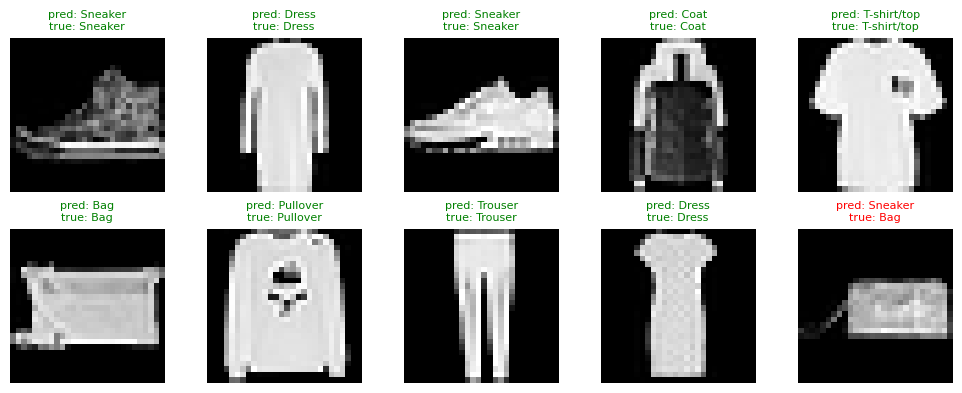

Test accuracy: 86.66%


In [5]:
X_test_t = Tensor(X_test)
y_test_t = Tensor(y_test_onehot)

log_probs_test = model(X_test_t).log_softmax(axis=1)
test_loss = -(y_test_t * log_probs_test).sum().data / len(X_test)
test_preds = log_probs_test.data.argmax(axis=1)
test_acc = (test_preds == y_test).mean()

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
samples = rng.choice(len(X_test), 10, replace=False)
for ax, idx in zip(axes.flat, samples):
    predicted = test_preds[idx]
    true_label = y_test[idx]
    ax.imshow(X_test_raw[idx].reshape(28, 28), cmap="gray")
    ax.set_title(
        f"pred: {label_names[predicted]}\ntrue: {label_names[true_label]}",
        color="green" if predicted == true_label else "red",
        fontsize=8,
    )
    ax.axis("off")

plt.tight_layout()
plt.show()

print(f"Test metrics | accuracy={test_acc:.2%}, loss={test_loss:.4f}")